# Sensitivity to the dipole anisotropy

Method: take realistic noise, create fake anisotropy sky and see how much of the dipole we can actually detect

In [1]:
from __future__ import division
import numpy as np
import healpy as hp  # need version 1.12.5 or higher
import matplotlib.pyplot as mp
from scipy.integrate import quad
from scipy.optimize import fsolve, curve_fit
from ipywidgets import FloatProgress
from IPython.display import display
import os
import pickle
import numbers
from tools import *

Take the real isotropy and observation map. Both are produced by Maria, and both are in galactic coordinates with nside=16. We upgrade the nside and rotate the maps to the equatorial coordinates

In [2]:
iso_map = np.load('iso_map.npy')
nside = hp.npix2nside(len(iso_map))
print("Number of events - {}".format(iso_map.sum()))

Number of events - 403802.0


In [3]:
r = hp.rotator.Rotator(coord='GC')
# Optional parameter power=-2 allows to keep the integral of the map unchanged
iso_map = hp.ud_grade(iso_map, 32, power=-2)
iso_map = r.rotate_map_alms(iso_map)
nside = 16
iso_map = hp.ud_grade(iso_map, nside, power=-2)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


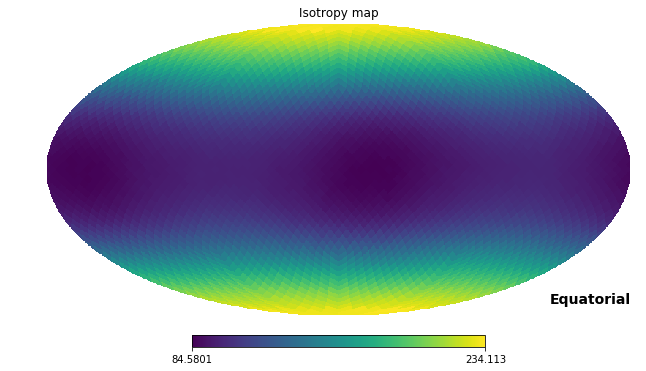

In [4]:
hp.mollview(iso_map, coord='C', title='Isotropy map')

In [5]:
dipole_ampl = 0.01
dipole_dir = (90, 0)

In [6]:
ani_model = create_dipole_map(nside, dipole_ampl, dipole_dir) + create_noise_map(iso_map)

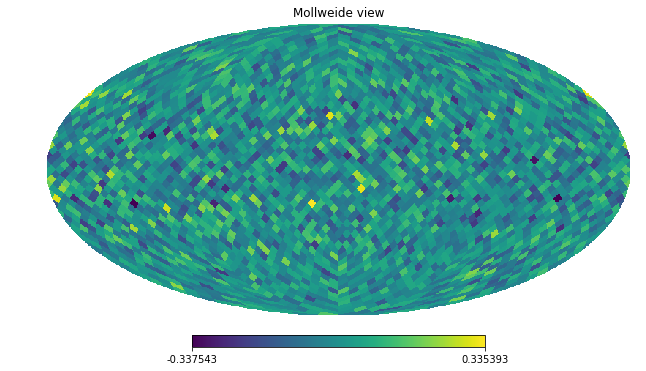

In [7]:
hp.mollview(ani_model)

The top-hat smoothing is often explained as an integration in a circle. I believe that it is not correct. Instead I use the
- averaged-in-circles sky
- normalised to the number of pixels under the circle mask

In [8]:
smoothed, Npix = tophat_smoothing(ani_model, 90)

FloatProgress(value=0.0, max=3072.0)

Reconstructed/input dipole amplitude = 0.0064/0.0100


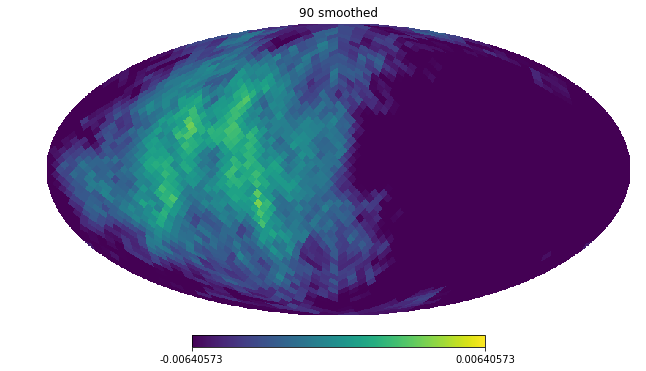

In [9]:
fac = 1.
drec = get_dipole_ampl(smoothed)
hp.mollview(smoothed, title='90 smoothed',
            min=-fac*drec, max=fac*drec)
print('Reconstructed/input dipole amplitude = {:.4f}/{:.4f}'.
      format(drec, dipole_ampl))

Significance for each pixel of the smoothed map is

$\sqrt{{N_{obs} N_{pix}}\over {1 + \alpha}} \delta I$

where $N_{obs}$ is the number of observations in this pixel (iso_map) and $N_{pix}$ is the number of pixels over which we were taking the mean

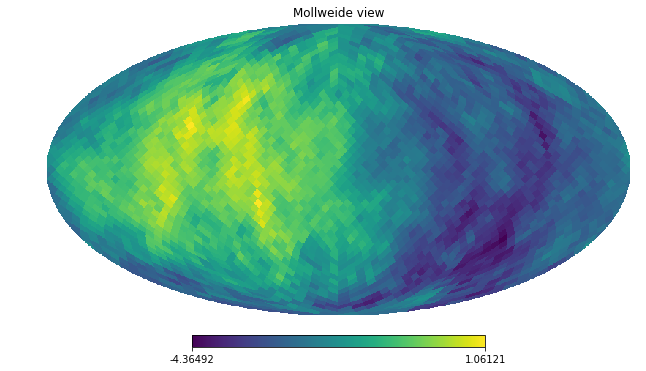

In [10]:
sig_map = get_sig_map(smoothed, iso_map, 1, Npix)
hp.mollview(sig_map)

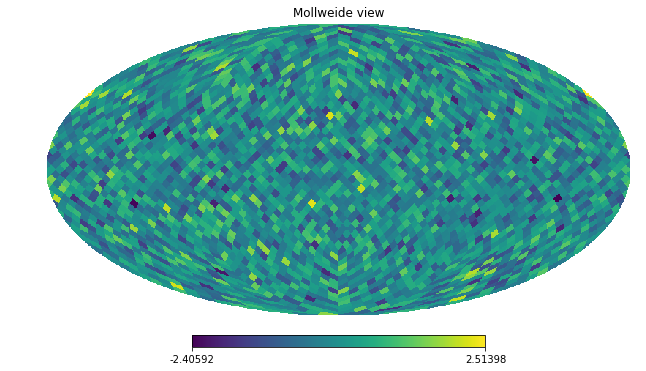

In [11]:
sig_map = get_sig_map(ani_model, iso_map, 1)
hp.mollview(sig_map)

## In order to get the sensitivity, run many realisations

To make things faster, reduce the nside

In [12]:
nside = 4
iso_map = hp.ud_grade(iso_map, nside, power=-2)

In [13]:
def one_realisation(dipole_ampl, dipole_dir, iso_map):
    '''
    Run one realisation of the sky,
        smooth it on 90 deg
        and then estimate the dipole
    Return reconstructed dipole amplitude
        and the distance of the reconstructed dipole vector
        from the original one.
        If the input dipole_ampl == 0,
        then retrun the reconstructed amplitude
        and the declination of the reconstructed dipole
    '''
    nside = hp.npix2nside(len(iso_map))
    ani_model = create_dipole_map(nside, dipole_ampl, dipole_dir)
    if dipole_dir is None:
        orig_dir = get_dipole_dir(ani_model)
    elif dipole_ampl == 0:
        orig_dir = (0., 0.)
    else:
        orig_dir = dipole_dir
    ani_model += create_noise_map(iso_map)
    smoothed, Npix = tophat_smoothing(ani_model, 90, 
                                      progress=False)
    rec_ampl = get_dipole_ampl(smoothed)
    rec_dir = get_dipole_dir(smoothed)

    if dipole_ampl == 0:
        dist = rec_dir[1]
    else:
        dist = np.degrees(hp.rotator.angdist(orig_dir, 
                                             rec_dir, lonlat=True))[0]
    return rec_ampl, dist

In [17]:
N = 10000 # number of realisation for each set of input parameters

dipole_ampl = 0.0
dipole_dir = None
# dipole_ampl = 1e-2
# dipole_dir = (90, 0)

f = FloatProgress(min=0, max=N)
display(f)

ampl = np.empty(N)
d = np.empty(N)

for i in xrange(N):
    ampl[i], d[i] = one_realisation(dipole_ampl, 
                                    dipole_dir, 
                                    iso_map)
    f.value += 1

FloatProgress(value=0.0, max=10000.0)

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/healpy/pixelfunc.py:751: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(vectors[:, 2] / dnorm)


Use this if you were running the $\delta \neq 0$ simulations

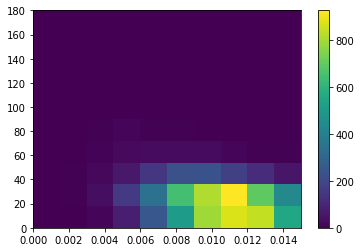

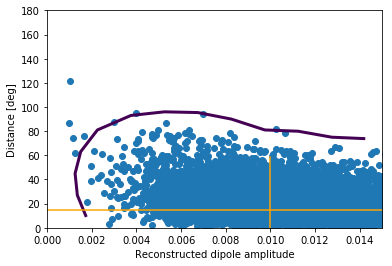

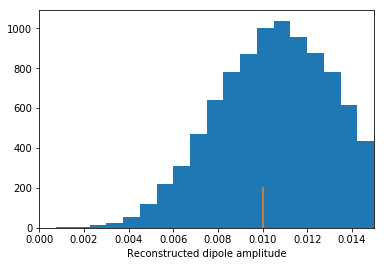

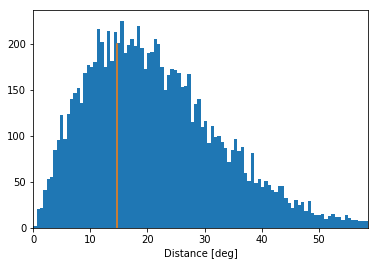

Dipole amplitude reconstruced = 0.0109 +- 0.0029


In [15]:
reso = np.degrees(hp.nside2resol(nside))
xlim = 0.015 #dipole_ampl * 2.
ylim = reso * 4.
counts, xbins, ybins, image = mp.hist2d(ampl, d, bins=[10, 10], 
                                        range=[[0., xlim], #5*xlim], 
                                               [0., 180.]])
mp.colorbar()
mp.show()

mp.scatter(ampl, d)
xbw = (xbins[1] - xbins[0]) / 2.
ybw = (ybins[1] - ybins[0]) / 2.
mp.contour(xbins[:-1] + xbw, ybins[:-1] + ybw, counts.T,  
           extent=[xbins.min(), xbins.max(),
                   ybins.min(), ybins.max()], 
           linewidths=3,
           levels=2) #[N*0.6826, N*0.9544])
mp.plot([dipole_ampl, dipole_ampl], [0., ylim], c='orange')
mp.plot([0., xlim], [reso, reso], c='orange')
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Distance [deg]')
mp.xlim(0., xlim)
mp.ylim(0., 180.)# ylim)
mp.show()

n, bins, patches = mp.hist(ampl, 20, range=(0., xlim))
mp.plot([dipole_ampl, dipole_ampl], [0., 200.])
mp.xlabel('Reconstructed dipole amplitude')
mp.xlim(0., xlim)
mp.show()

mp.hist(d, 100, range=(0., ylim))
mp.plot([reso, reso], [0., 200.])
mp.xlabel('Distance [deg]')
mp.xlim(0., ylim)
mp.show()

print('Dipole amplitude reconstruced = {:.4f} +- {:.4f}'.\
      format(ampl.mean(), ampl.std()))

And use this code, if that were the $\delta = 0$ simulations!

95% C.L. upper limit = 0.00818392444731


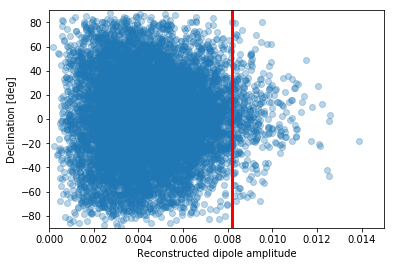

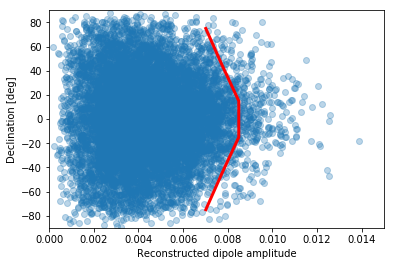

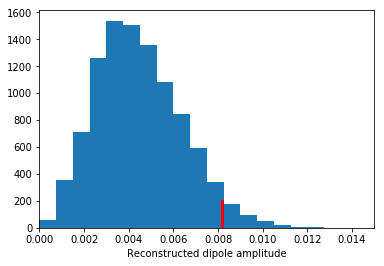

In [18]:
xlim = 0.015
mp.scatter(ampl, d, alpha=0.3)
ul_obj = UpperLimit(ampl)
lim = ul_obj.get_upper_limit()
print('95% C.L. upper limit = {}'.format(lim))
mp.plot([lim, lim], [-90., 90.], c='r', lw=3)
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Declination [deg]')
mp.xlim(0., xlim)
mp.ylim(-90., 90.)
mp.show()

mp.scatter(ampl, d, alpha=0.3)
dec_ar = np.array([75, 45, 15, -15, -45, -75])
dec_bw = 30
ul_temp = np.empty(len(dec_ar))
for k, dec in enumerate(dec_ar[:3]):
    mask = np.abs(np.abs(d) - dec) < dec_bw / 2.
    ul_obj = UpperLimit(ampl[mask])
    ul_temp[k] = ul_obj.get_upper_limit()
ul_temp[3:] = ul_temp[:3][::-1]
mp.plot(ul_temp, dec_ar, lw=3, c='r')
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Declination [deg]')
mp.xlim(0., xlim)
mp.ylim(-90., 90.)# ylim)
mp.show()

n, bins, patches = mp.hist(ampl, 20, range=(0., xlim))
mp.plot([lim, lim], [0., 200.], lw=3, c='r')
mp.xlabel('Reconstructed dipole amplitude')
mp.xlim(0., xlim)
mp.show()

### Dipole upper limit
The dipole upper limit is defined by the probability to observe some dipole amplitude while actually there is no anisotropy in the sky. There is lower chance to observe a fake dipole toward the equatorial poles, because on the poles we have more statistics. Thus we can get the upper limit which is both energy and declination dependent.

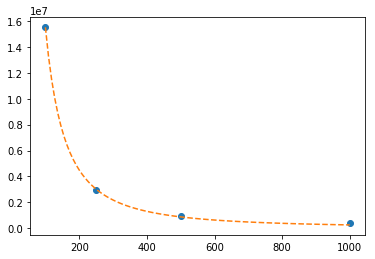

In [19]:
E_ar = np.array([100., 250., 500., 1000.])
stat = np.array([15521572, 2954456, 927621, iso_map.sum()])

mp.plot(E_ar, stat, 'o')
from scipy.optimize import curve_fit
def edep(e, n, spectral_index):
    return n * e**spectral_index
p, pe = curve_fit(edep, E_ar, stat, p0=[1e9, -2])
# print('Reconstructed spectral index = {}'.format(p[1]))
e = np.linspace(E_ar[0], E_ar[-1], 100)
f = edep(e, p[0], p[1])
mp.plot(e, f, '--') #, label='Spectral index = {:.2f}'.format(p[1]))
# mp.legend()
mp.show()

In [20]:
dec_bw = 45.
dec_ar = np.arange(-90., 90, dec_bw) + dec_bw / 2.

In [21]:
N = 10000
dipole_ampl = 0

f = FloatProgress(min=0, max=N * len(E_ar))
display(f)

# dipole upper limit independent of declination
ul = np.empty(len(E_ar))
# dipole upper limit as fun of E and dec
ul_dec = np.empty((len(E_ar), len(dec_ar)))

for j, e in enumerate(E_ar):
    iso_map_scaled = iso_map / iso_map.sum()
    iso_map_scaled *= stat[j:].sum()

    ampl = np.empty(N)
    dec = np.empty(N)

    for i in xrange(N):
        ampl[i], dec[i] = one_realisation(dipole_ampl, 
                                          None, 
                                          iso_map_scaled)
        f.value += 1
        
    for k, d in enumerate(dec_ar[:2]):
        mask = np.abs(np.abs(dec) - np.abs(d)) < dec_bw / 2.
        ul_obj = UpperLimit(ampl[mask])
        ul_dec[j][k] = ul_obj.get_upper_limit()
    ul_dec[j][2:] = ul_dec[j][:2][::-1]
        
    ul_obj = UpperLimit(ampl)
    ul[j] = ul_obj.get_upper_limit()

FloatProgress(value=0.0, max=40000.0)

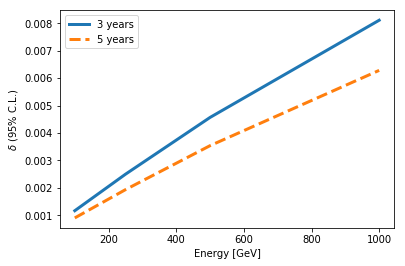

In [22]:
mp.plot(E_ar, ul, lw=3, label='3 years')
mp.plot(E_ar, ul / (5 / 3)**0.5, '--', lw=3, label='5 years')
mp.legend()
mp.xlabel('Energy [GeV]')
mp.ylabel('$\delta$ (95% C.L.)')
mp.show()

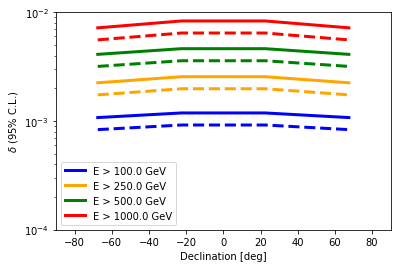

In [23]:
color = ['blue', 'orange', 'green', 'red']
for i, e in enumerate(E_ar):
    mp.semilogy(dec_ar, ul_dec[i], 
                lw=3, color=color[i], 
                label='E > {} GeV'.format(e))
    mp.plot(dec_ar, ul_dec[i] / (5 / 3)**0.5, 
            '--', lw=3, color=color[i])
mp.legend()
mp.xlabel('Declination [deg]')
mp.ylabel('$\delta$ (95% C.L.)')
mp.xlim(-90, 90)
mp.ylim(1e-4, 1e-2)
mp.show()

If you eventually measure some inconclusive dipole amplitude, let's say $3.9 \cdot 10^{-4}$, the "experiment" upper limit will be:

In [24]:
UpperLimit.get_experimental_ul(3.9e-4, cl=0.95)

0.0011395312499999995